## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

 Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


find the number of rows in the dataset and information about the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


find the number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

Proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't match.

In [6]:
treat_old= df[(df['group']=='treatment') & (df['landing_page']=='old_page')]
control_new = df[(df['group']=='control') & (df['landing_page']=='new_page')]
treat_old.shape[0]+control_new.shape[0]

3893

Checks if there is missing values

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. So we will drop them from the dataset.  

create a new dataset and Store the new dataframe in df2

In [8]:
delete = control_new.append(treat_old).index
df2 = df.drop(delete)


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in df2?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.user_id.duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**.

In [13]:
#df2.drop_duplicates(inplace=True)
df2.drop(2893, inplace=True)



the probability of an individual converting regardless of the page they receive

In [14]:
all_convert = df2.converted.mean()
all_convert

0.11959708724499628

Given that an individual was in the `control` group, the probability they converted

In [15]:
control_convert = df2[df2.group == 'control']['converted'].mean()
control_convert

0.1203863045004612

 Given that an individual was in the `treatment` group, the probability they converted

In [16]:
treat_convert = df2[df2.group == 'treatment']['converted'].mean()
treat_convert

0.11880806551510564

the probability that an individual received the new page

In [17]:
(df2.landing_page =='new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**control group that convertes = 0.1204**
**treatment group that converted = 0.1188**

**From the result above we observed that control group is better than treatment group, but we can not with this because the difference is very low so we should go with hypothesis test to check with p_value**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

Null Hypotheses: $p_{old}$ is greater than or equal to $p_{new}$

$H_{0}$ : $p_{new}$ - $p_{old}$ <= 0

Alternative Hypothesis: $p_{old}$ is less than $p_{new}$

$H_{1}$ : $p_{new}$ - $p_{old}$ > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
all_convert

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
all_convert

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2[df2.landing_page == 'new_page'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[all_convert, (1 - all_convert)])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[all_convert, (1 - all_convert)])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted.mean() - old_page_converted.mean()

5.6987654927453946e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - all_convert), all_convert])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - all_convert), all_convert])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [26]:
p_diffs = np.asarray(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0,0.5,' count')

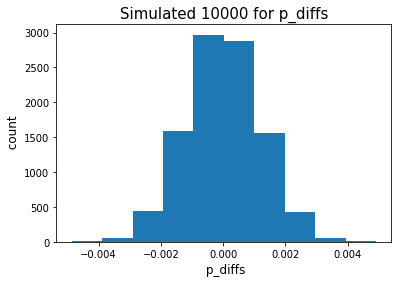

In [27]:
plt.hist(p_diffs)
plt.title("Simulated 10000 for p_diffs", fontsize=15)
plt.xlabel(" p_diffs", fontsize=12)
plt.ylabel(" count", fontsize=12)

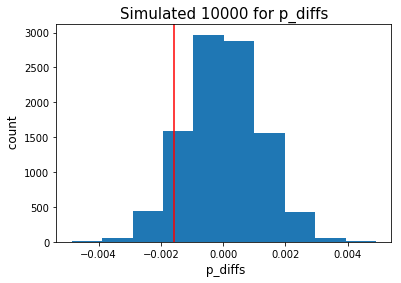

In [28]:
plt.hist(p_diffs)
plt.title("Simulated 10000 for p_diffs", fontsize=15)
plt.xlabel(" p_diffs", fontsize=12)
plt.ylabel(" count", fontsize=12)
plt.axvline(treat_convert - control_convert, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
obs_diff = treat_convert - control_convert

(p_diffs > obs_diff).mean()

0.90720000000000001

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**I compute P-Value in part J**

**P-Value = 0.90720**

**To reject the null hypothesis the p-value must be bigger than 0.95 or less than 0.05**

**we fail to reject the null hypothesis**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2[df2.landing_page == 'old_page']['converted'].sum()
convert_new = df2[df2.landing_page == 'new_page']['converted'].sum()
n_old = df2[df2.group == 'control'].shape[0]
n_new = df2[df2.group == 'treatment'].shape[0]

convert_old , convert_new , n_old , n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
z_score , p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

p_value , z_score

(0.90505831275902449, 1.3109241984234394)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**after doing the z-score test, Since the z-score of 1.31 less than the critical value of 1.64485362695.**

**and from p-value we can confidently say we fail to reject the null hypothsis**

**Yes, agreed with parts J and K**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**I will perform Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [33]:
log_reg = sm.Logit(df2['converted'], df2[['intercept', 'treatment']])
result = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        05:00:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**P-Value associated with ab_page = 0.190**

**It different from the previous P-Value because here the intercept added so we do two side test**



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**1- duration ... increasing the duration.**

**2- time  ... may some users spent more time in the afternon**

**but may we have more complexity and multicollinearity which is a problem**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [35]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
countries_df.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [37]:
df3 = pd.merge(df2, countries_df, how='inner', on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


In [38]:
df3[['UK','US']] = pd.get_dummies(df3['country'])[['UK','US']]
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,1


In [39]:
log_reg = sm.Logit(df3['converted'], df3[['intercept', 'UK', 'US']])
result = log_reg.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 24 Jun 2020   Pseudo R-squ.:               1.521e-05
Time:                        05:00:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""


<a id='conclusions'></a>
## Finishing Up
**based on what we have of information and data , we do not have sufficient evidence to suggest that the new page results in more conversions than the old page**

## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [41]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0